# Genetic Optimization (GO)

## Quick introduction

<img src="img/go_overview.png">

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, '../src'))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

In [2]:
# Import external librarires
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Import our code
from heur import FastSimulatedAnnealing, GeneticOptimization
from heur_mutations import Correction, CauchyMutation
from objfun import TSPGrid

**Let's use the well-known ``TSPGrid(3, 3)`` for demonstration purposes**

In [3]:
tsp = TSPGrid(3, 3)

## GO building blocks demo

### 1. Selection

* **Rank based, using exponential distribution**
* Let $U$ be random variable from uniform distribution and $\lambda \in \mathbb{R}$ ($1/\lambda$ will be the *selection temperature*)
* We can **select** $R$-th solution from sorted population as follows:

$$ R = \lceil \frac{-\ln(U)}{\lambda} \rceil $$

In [4]:
# Let's generate 1000 random numbers
u = np.random.uniform(low=0.0, high=1.0, size=1000)

In [5]:
# And the selection function
def demo_select(T):
    return np.ceil(-T*np.log(u))

#### Low temperature -> first (the best one) solution is selected always:

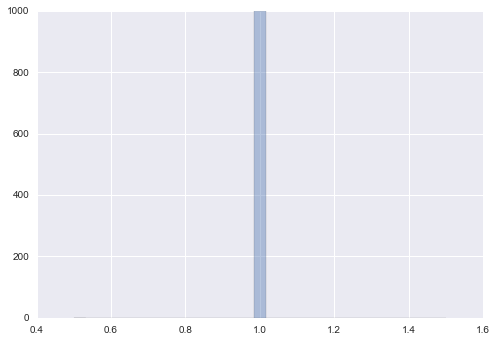

In [6]:
k = demo_select(0.1)
ax = sns.distplot(k, kde=False)

#### Medium temperature

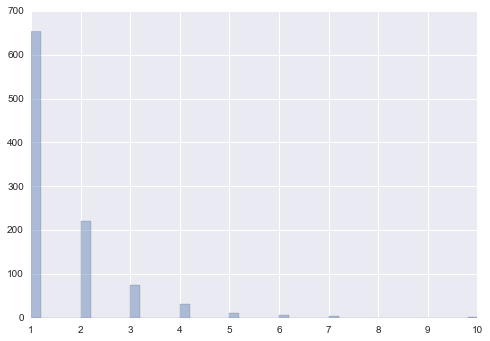

In [7]:
k = demo_select(1)
ax = sns.distplot(k, kde=False)

#### Higher temperature

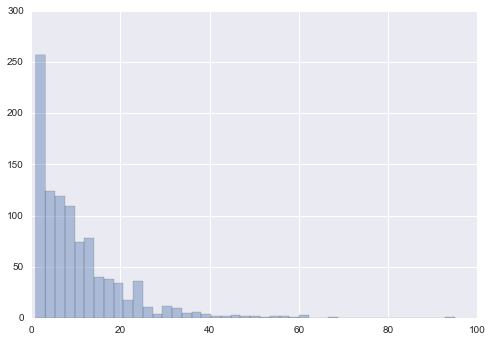

In [8]:
k = demo_select(10)
ax = sns.distplot(k, kde=False)

### 2. Crossover

* Many possibilities, let's start with **uniform multi point crossover**:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/OnePointCrossover.svg/231px-OnePointCrossover.svg.png">

In [9]:
def crossover(x, y, m):
    m=m+1  # m ... number of crossover points
    n=np.size(x)
    z=x*0
    k=0
    p=np.ceil(n/m).astype(int)
    for i in np.arange(1, m+1):
        ix_from = k
        ix_to = np.minimum(k+p, n)
        z[ix_from:ix_to] = x[ix_from:ix_to] if np.mod(i, 2) == 1 else y[ix_from:ix_to]
        k += p
    return z

In [10]:
c = crossover(
    np.array([1, 1, 1, 1, 1, 1], dtype=int), 
    np.array([0, 0, 0, 0, 0, 0], dtype=int), 
    1)
print(c)

[1 1 1 0 0 0]


In [11]:
c = crossover(
    np.array([1, 1, 1, 1, 1, 1], dtype=int), 
    np.array([0, 0, 0, 0, 0, 0], dtype=int), 
    2)
print(c)

[1 1 0 0 1 1]


In [12]:
c = crossover(
    np.array([1, 1, 1, 1, 1, 1], dtype=int), 
    np.array([0, 0, 0, 0, 0, 0], dtype=int), 
    5)
print(c)

[1 0 1 0 1 0]


### 3. Mutation

* We can re-use Cauchy or Gaussian one (this time).

## Run GO and test different population sizes

In [13]:
NUM_RUNS = 1000
maxeval = 1000

In [14]:
# traditional testing procedure setup
def experiment_go(of, maxeval, num_runs, N, M, Tsel1, Tsel2, mutation, co_n):
    results = []
    heur_name = 'GO_{}'.format(N)
    for i in tqdm_notebook(range(num_runs), 'Testing {}'.format(heur_name)):
        result = GeneticOptimization(of, maxeval, N=N, M=M, Tsel1=Tsel1, Tsel2=Tsel2, mutation=mutation, co_n=co_n).search()
        result['run'] = i
        result['heur'] = heur_name
        result['N'] = N
        results.append(result)
    return pd.DataFrame(results, columns=['heur', 'run', 'N', 'best_x', 'best_y', 'neval'])

In [15]:
results = pd.DataFrame()
mutation = CauchyMutation(r=1.0, correction=Correction(tsp))
for N in [1, 2, 3, 5, 10, 20, 30, 100]:
    res = experiment_go(of=tsp, maxeval=maxeval, num_runs=NUM_RUNS, N=N, M=N*3, Tsel1=0.1, Tsel2=1, mutation=mutation, co_n=1)
    results = pd.concat([results, res], axis=0)

In [16]:
# from: 20170306_Steepest_descent_vs_Random_descent.ipynb#Overall-statistics
def rel(x):
    return len([n for n in x if n < np.inf])/len(x)
def mne(x):
    return np.mean([n for n in x if n < np.inf])
def feo(x):
    return mne(x)/rel(x)

In [17]:
results_pivot = results.pivot_table(
    index=['heur', 'N'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_pivot = results_pivot.reset_index()
results_pivot.sort_values(by='N')

,heur,N,rel,mne,feo
0,GO_1,1,0.677,388.796160,574.292702
3,GO_2,2,0.902,340.539911,377.538704
5,GO_3,3,0.955,310.647120,325.284943
7,GO_5,5,0.955,293.741361,307.582577
1,GO_10,10,0.965,307.041451,318.177669
4,GO_20,20,0.928,320.406250,345.265356
6,GO_30,30,0.891,324.868687,364.611321
2,GO_100,100,0.809,383.266996,473.754013


## Assignment

* Thoroughly analyze effects of other parameters on GO performance
* Make use of the detailed log to verify your assumptions